# generate / update a DataDiVR backend project 

In [1]:
#####################################################
# FUNCTIONS TO GENERATE LAYOUT DATA FOR THE DATADIVR 
# based on a nx.Graph object
#####################################################
 





In [2]:
import networkx as nx
import json 
import os

G = nx.random_geometric_graph(30,0.4)
print("Number of nodes: ", len(G.nodes()))
print("Number of Links: ", len(G.edges()))

# generate graph layouts i.e. node positions 
posG3D_1_pre = nx.spring_layout(G, dim=3, k=0.1, iterations=100)
posG3D_1 = {key: value.tolist() for key, value in posG3D_1_pre.items()}

posG3D_2_pre = nx.spring_layout(G, dim=3, k=0.1, iterations=200)
posG3D_2= {key: value.tolist() for key, value in posG3D_2_pre.items()}

posG3D_3_pre =nx.spring_layout(G, dim=3, k=0.1, iterations=500)
posG3D_3 = {key: value.tolist() for key, value in posG3D_3_pre.items()}

# hex color values 
d_nodecolors_hex = dict(zip(G.nodes(),['#FF2300']*len(G.nodes())))
l_linkcolors_hex = '#ff0000'

# rgba color values
d_nodecolors_rgba = dict(zip(G.nodes(),[(255,35,0,120)]*len(G.nodes())))
l_linkcolors_rgba = (0,255,0,100)

# hex8 color values
d_nodecolors_hex8 = dict(zip(G.nodes(),['#0000ffaa']*len(G.nodes())))
l_linkcolors_hex8 = '#0080ffaa'

# ===============================================
# ANNOTATIONS - new ! (dictionary)
# ===============================================
l_annotations_json = []
d_degree = dict(G.degree())
d_eigen = dict(nx.eigenvector_centrality(G))
for g in G.nodes():
    sublist = {"Node: ":g, "Degree: ":d_degree[g], "Eigenv: ": round(d_eigen[g],2)}
    l_annotations_json.append(sublist)
        
d_annotations = dict(zip(G.nodes(), l_annotations_json))
nx.set_node_attributes(G, d_annotations, name="annotation")

# ===============================================
# GRAPH NAME AND DESCRIPTION - a string each
# ===============================================
G.name = "ToyNetwork"
G.graph['graphtitle'] = G.name
G.graph['graphdesc'] = "A toy graph for testing purposes. Number of nodes: "+str(len(G.nodes()))+", Links: "+ str(len(G.edges()))+"."


# ===============================================
# NODE COLORS - a dict with keys = node id as in G.nodes and values = color as hex or rgba
# LINK COLORS - a list of hex or rgba colors per edge as in G.edges or one color for all edges
# ===============================================
#                     a n d 
# ===============================================
# NODE POSITIONS - a dict with keys = G.nodes and values = coordinates (x,y) or (x,y,z)
# ===============================================

# first Layout - rgba
G_rgba = G.copy()
G_rgba.name = '01-graph-rgbacolors'
nx.set_node_attributes(G_rgba, d_nodecolors_rgba, name="nodecolor")
nx.set_edge_attributes(G_rgba, l_linkcolors_rgba, name="linkcolor")
nx.set_node_attributes(G_rgba, posG3D_1, name="pos")

# second Layout - hex
G_hex = G.copy()
G_hex.name = '02-graph-hexcolors'
nx.set_node_attributes(G_hex, d_nodecolors_hex, name="nodecolor")
nx.set_edge_attributes(G_hex, l_linkcolors_hex, name="linkcolor")
nx.set_node_attributes(G_hex, posG3D_2, name="pos")

# third Layout - hex8
G_hex8 = G.copy()
G_hex8.name = '03-graph-hex8colors'
nx.set_node_attributes(G_hex8, d_nodecolors_hex8, name="nodecolor")
nx.set_edge_attributes(G_hex8, l_linkcolors_hex8, name="linkcolor")
nx.set_node_attributes(G_hex8, posG3D_3, name="pos")


# fourth layout - cluster key next level communities
# artifical groups of graph for cluster colors 
G_clusters = G.copy()
G_clusters.name = '04-graph-clustershex8colors'


clustername_1 = 'group 1'
clustername_2 = 'group 2'
clustername_3 = 'group 3'

# nodes into groups
for g in G_clusters.nodes():
    if g < len(G_clusters.nodes()) / 3:
        G_clusters.nodes[g]['cluster'] = clustername_1
    elif g < 2 * len(G_clusters.nodes()) / 3:
        G_clusters.nodes[g]['cluster'] = clustername_2
    else:
        G_clusters.nodes[g]['cluster'] = clustername_3

# node colors 
d_nodecolors_clusters = {}
nodes_group1 = []
nodes_group2 = []
nodes_group3 = []
for n in G_clusters.nodes(): 
    if G_clusters.nodes[n]['cluster'] == clustername_1:
        d_nodecolors_clusters[n] = '#0000ffaa'
        nodes_group1.append(n)
    elif G_clusters.nodes[n]['cluster'] == clustername_2:
        d_nodecolors_clusters[n] = '#00ff00aa'
        nodes_group2.append(n)
    elif G_clusters.nodes[n]['cluster'] == clustername_3:
        d_nodecolors_clusters[n] = '#ff0000aa'
        nodes_group3.append(n)

# link colors
d_linkcolors_clusters = {}
for edge in G_clusters.edges():
    if edge[0] in nodes_group1 and edge[1] in nodes_group1:
        d_linkcolors_clusters[edge] = '#0000ffaa'
       
    elif edge[0] in nodes_group2 and edge[1] in nodes_group2:
        d_linkcolors_clusters[edge] = '#00ff00aa'
       
    elif edge[0] in nodes_group3 and edge[1] in nodes_group3:
        d_linkcolors_clusters[edge] = '#ff0000aa'
       
    else:
        d_linkcolors_clusters[edge] = '#B1B1B150'

l_linkcolors_clusters = list(d_linkcolors_clusters.values())

nx.set_node_attributes(G_clusters, d_nodecolors_clusters, name="nodecolor")
nx.set_node_attributes(G_clusters, posG3D_2, name="pos") # reuse the second layout
nx.set_edge_attributes(G_clusters, {edge: color for edge, color in zip(G_clusters.edges(), l_linkcolors_clusters)}, "linkcolor")

Number of nodes:  30
Number of Links:  188


## making our own GRAPH FORMAT : A Graph Dictionary 
+ with nodes and links and layouts as keys 

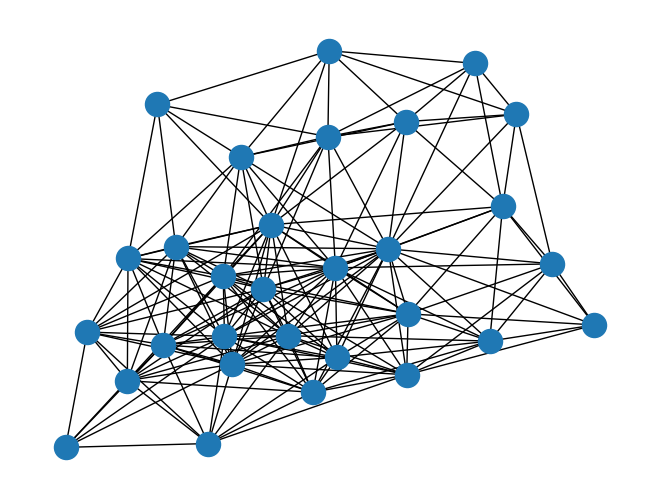

In [3]:
nx.draw(G)

In [4]:
def merge_graphs(graphs):
    all_nodes = []
    all_links = []
    layouts = []

    seen_nodes = set()  # To track seen node IDs
    seen_links = set()  # To track seen links by a tuple of (source, target)

    for graph in graphs:
        # Process nodes for global and layout-specific lists
        for node, attrs in graph.nodes(data=True):
            if node not in seen_nodes:
                annotation = attrs.get('annotation', [])
                all_nodes.append({'id': node, 'annotation': annotation})
                seen_nodes.add(node)

        # Process links for global list, now with separate source and target
        for ix,(source, target, attrs) in enumerate(graph.edges(data=True)):
            if (source, target) not in seen_links:
                # Assuming 'weight' might be an attribute you're interested in
                # weight = attrs.get('weight', 1)  # Example, uncomment if needed
                all_links.append({
                    'id': ix,  # It's unclear how 'id' is determined; might need a unique strategy
                    # 'w': weight,  # Uncomment if using weight
                    'source': source,
                    'target': target
                })
                seen_links.add((source, target))

        # Prepare layout-specific nodes and links
        layout_nodes = [{'nodecolor': attrs.get('nodecolor', ''),
                         'pos': attrs.get('pos', []),
                         'id': node} for node, attrs in graph.nodes(data=True)]
        layout_links = [{'linkcolor': attrs.get('linkcolor', ''),
                         's': source,
                         'e': target} for source, target, attrs in graph.edges(data=True)]

        layouts.append({'nodes': layout_nodes, 'links': layout_links})

    # Assuming the structure of the graphs are similar, and using the first graph as the base
    graphlayouts = [graph.name for graph in graphs]
    merged_structure = {
        'directed': graphs[0].is_directed(),
        'multigraph': graphs[0].is_multigraph(),
        'graphtitle': graphs[0].graph.get("graphtitle", ""),
        'graphdesc': graphs[0].graph.get("graphdesc", ""),
        'graphlayouts': graphlayouts,
        'nodes': all_nodes,
        'links': all_links,
        'layouts': layouts
    }

    return merged_structure


In [5]:
Graphs = [G_rgba, G_hex, G_hex8, G_clusters]
G_merged = merge_graphs(Graphs)

In [6]:
len(G_rgba.nodes)

30

In [7]:
len(G_merged["links"])

188

In [37]:
####################################
#
# make folder of project 
#
####################################


def makeProjectFolders(name):
    path = "static/projects/" + name

    try:
        os.mkdir(path)
        os.mkdir(path + '/layouts')
        os.mkdir(path + '/layoutsl')
        os.mkdir(path + '/layoutsRGB')
        os.mkdir(path + '/links')
        os.mkdir(path + '/linksRGB')
        os.mkdir(path + '/legends')
        
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)

projectname = G_merged["graphtitle"]
path = "static/projects/"

makeProjectFolders(projectname)

Creation of the directory static/projects/ToyNetwork failed


In [20]:
####################################
#
# make nodes json
#
####################################

def create_nodesjson(graph):
    nodes = {"nodes": []}
    for node, attrs in enumerate(graph["nodes"]):
        # Initialize a dictionary for attrlist
        attrlist = {}
        # Iterate through all attributes
        for key, value in attrs.items():
            # check for annotation key
            if key == "annotation":
                # Check if the value is already a list
                if isinstance(value, list):
                    attrlist[key] = value
                elif isinstance(value, dict):
                    # For dictionaries, iterate through inner keys
                    for inner_key, inner_value in value.items():
                        # Ensure each inner key maps to a list
                        if inner_key not in attrlist:
                            attrlist[inner_key] = [inner_value]
                        else:
                            attrlist[inner_key].append(inner_value)
                else:
                    # For non-list and non-dict attributes, create or append to a list
                    if key not in attrlist:
                        attrlist[key] = [value]
                    else:
                        attrlist[key].append(value)
            
        # Constructing node data
        node_data = {
            "id": node,
            "annotation": attrlist,
            "n": f"node {node}"
        }
        nodes["nodes"].append(node_data)
    return nodes


nodes_for_json = create_nodesjson(G_merged)
with open(path + projectname + '/nodes.json', 'w') as outfile:
    json.dump(nodes_for_json, outfile)

In [21]:
####################################
#
# make links.json 
#
####################################

def create_linksjson(graph):
    links = {"links": []}
    for each_edge in graph["links"]: 
        links["links"].append({"id": each_edge['id'], "source": each_edge['source'], "target": each_edge['target']})
    return links

links_for_json = create_linksjson(G_merged)
with open(path + projectname + '/links.json', 'w') as outfile:
    json.dump(links_for_json, outfile)

In [22]:
####################################
#
# make textures
#
####################################

from PIL import Image
from sklearn import preprocessing
from math import cos, radians, sin, sqrt

from uploaderGraph import hex_to_rgb, hex_to_rgba
from uploader import normalize_xyz, geodetic_to_geocentric


def makeXYZTexture_G(project, nodepos, name=None): 

    hight = 128 * (int((len(nodepos)) / 16384) + 1)

    print ("hight is " + str(hight))
    size = 128 * hight 
    path = 'static/projects/' + project 
    
    texh = [(0,0,0)] * size
    texl = [(0,0,0)] * size

    if "_geo" in name:
        #print("is geo")
        unscaled = []
        # convert lat lon to XYZ
        for x in nodepos:
            unscaled.append(geodetic_to_geocentric(float(x[0]), float(x[1])))
        # Normalize to 0-1 range
        scaled = normalize_xyz(unscaled)
        
        for i in range(len(scaled[0])):
            
            x = int(float(scaled[0][i])*65280)
            y = int(float(scaled[1][i])*65280)
            z = int(float(scaled[2][i])*65280)

            xh = int(x / 255)
            yh = int(y / 255)
            zh = int(z / 255)

            xl = x % 255
            yl = y % 255
            zl = z % 255

            pixelh = (xh,yh,zh)
            pixell = (xl,yl,zl)

            texh[i] = pixelh
            texl[i] = pixell
    
    else:
       
        x_norm = []
        y_norm = []
        z_norm = []
        for i in range(len(nodepos)):
                
            x = float(nodepos[i][0])
            y = float(nodepos[i][1])
            z = float(nodepos[i][2])
            
            x_norm.append(x)
            y_norm.append(y)
            z_norm.append(z)

        # check on coordinates - if normalized        
        if min(x_norm)<0 or min(y_norm)<0 or min(z_norm)<0 or max(x_norm)>1 or max(y_norm)>1 or max(z_norm)>1:
            coordinates_norm = normalize_xyz(nodepos) 
            for i in range(len(coordinates_norm[0])):
                        
                x = int(float(coordinates_norm[0][i])*65280)
                y = int(float(coordinates_norm[1][i])*65280)
                z = int(float(coordinates_norm[2][i])*65280)

                xh = int(x / 255)
                yh = int(y / 255)
                zh = int(z / 255)

                xl = x % 255
                yl = y % 255
                zl = z % 255

                pixelh = (xh,yh,zh)
                pixell = (xl,yl,zl)

                texh[i] = pixelh
                texl[i] = pixell

        else:
            for i in range(len(nodepos)):

                x = int(float(nodepos[i][0])*65280)
                y = int(float(nodepos[i][1])*65280)
                z = int(float(nodepos[i][2])*65280)

                xh = int(x / 255)
                yh = int(y / 255)
                zh = int(z / 255)

                xl = x % 255
                yl = y % 255
                zl = z % 255

                pixelh = (xh,yh,zh)
                pixell = (xl,yl,zl)

                texh[i] = pixelh
                texl[i] = pixell
                #print(pixelh)
                #print("C_DEBUG: DID NOT normalize coordinates.")

    new_imgh = Image.new('RGB', (128, hight))
    new_imgl = Image.new('RGB', (128, hight))

    new_imgh.putdata(texh)
    new_imgl.putdata(texl)

    pathXYZ = path + '/layouts/' +  project + str(name) + 'XYZ.bmp'
    pathXYZl = path + '/layoutsl/' +  project + str(name) + 'XYZl.bmp' 
    #if name is not None:
    #    pathXYZ = path + '/layouts/' +  str(name) + '.bmp'
    #    pathXYZl = path + '/layoutsl/' +  str(name)  + 'l.bmp' 

    if os.path.exists(pathXYZ):
        return '<a style="color:red;">ERROR </a>' + project + str(name) + " Nodelist already in project"
    else:
        new_imgh.save(pathXYZ)
        new_imgl.save(pathXYZl)
        return '<a style="color:green;">SUCCESS </a>' + project + str(name) + " Node Textures Created"

In [23]:
import re 

def makeNodeRGBTexture_G(project, nodecolors, name): 
    
    rgba_colors = []

    # check if data is rgba or hex string
    for i,color in enumerate(nodecolors):

        if isinstance(color, str):  
            # if HEX FORMAT
            if re.match(r'^#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})$', color):
                _r, _g, _b = hex_to_rgb(color)
                rgba_color = (_r, _g, _b, 100)
                rgba_colors.append(rgba_color)

            # if HEX FORMAT with alpha
            elif re.match(r'^#([A-Fa-f0-9]{8})$', color):
                rgba_color = hex_to_rgba(color)
                rgba_colors.append(rgba_color)

            # if RGBA FORMAT
            elif re.match(r'^rgba\((\d+),(\d+),(\d+),(\d+)\)$', color) or re.match(r'^\((\d+),(\d+),(\d+),(\d+)\)$', color) or re.match(r'^RGBA\((\d+),(\d+),(\d+),(\d+)\)$', color):
                rgba = re.findall(r'\d+', color)
                rgba_color = tuple(map(int, rgba))
                rgba_colors.append(rgba_color)

            elif isinstance(color, tuple) and len(color) == 4:
                #print("C_DEBUG: link color is tuple")  
                rgba_colors.append(color)
            
            elif isinstance(color, list) and len(color) == 4:
                #print("C_DEBUG: link color is list")  
                rgba_colors.append(tuple(color))

            else:
                print("C_DEBUG: NO rgba_colors FOUND")
                rgba_colors.append((255, 0, 255, 100))
            
        else:   
            rgba_colors.append(color)

    hight = 128 * (int((len(nodecolors)) / 16384) + 1)

    size = 128 * hight 
    path = 'static/projects/' + project 
    tex = [(128,0,0,100)] * size

    for i in range(len(rgba_colors)): #pixeldata["data"])):
        tex[i] = (int(rgba_colors[i][0]), int(rgba_colors[i][1]),int(rgba_colors[i][2]),int(rgba_colors[i][3]))

    new_img = Image.new('RGBA', (128, hight))
    new_img.putdata(tex)
    pathXYZ = path + '/layoutsRGB/' +  str(name) +  'RGB.png'

    if os.path.exists(pathXYZ):
        return print("Already in project: " + name) #'<a style="color:red;">ERROR </a>' + str(name)  + " colors already in project"
    else:
        new_img.save(pathXYZ , "PNG")
        return print("Done with bitmap: " + name) #'<a style="color:green;">SUCCESS </a>' + str(name)  + " Node Textures Created"

In [24]:
layouts_nodes = {}
layouts_links = {}
for name,layout in zip(G_merged["graphlayouts"],G_merged["layouts"]):
    layouts_nodes[name] = layout["nodes"]
    layouts_links[name] = layout["links"]

# layout positions and RGB colors
for name,layout in layouts_nodes.items():
    d_nodepos = {node["id"]: node["pos"] for node in layout}
    nodepos = list(d_nodepos.values())
    makeXYZTexture_G(projectname, nodepos, name)

    d_nodecol = {node["id"]: node["nodecolor"] for node in layout}
    nodecolors = list(d_nodecol.values())
    makeNodeRGBTexture_G(projectname, nodecolors, name)

hight is 128
Done with bitmap: 01-graph-rgbacolors
hight is 128
Done with bitmap: 02-graph-hexcolors
hight is 128
Done with bitmap: 03-graph-hex8colors
hight is 128
Done with bitmap: 04-graph-clustershex8colors


In [25]:
def makeLinkTex_G(project, links, name): 

    hight = 64 * (int((len(links)) / 32768) + 1)
    path = 'static/projects/' + project 

    texl = [(0,0,0)] * 1024 * hight
    new_imgl = Image.new('RGB', (1024, hight))
    i = 0

    linklist = {}
    linklist["links"] = []
    try:
        for row in links:
            thislink = {}
            thislink["id"] = i
            thislink["source"] = row[0]
            thislink["target"] = row[1]
            linklist["links"].append(thislink)

            sx = int(row[0]) % 128 # R
            syl = int(int(row[0]) / 128) % 128 # G
            syh = int(int(row[0]) / 16384) # B

            ex = int(row[1]) % 128
            eyl = int(int(row[1]) / 128) % 128
            eyh = int(int(row[1]) / 16384)


            pixell1 = (sx,syl,syh)
            pixell2 = (ex,eyl,eyh)

            #if i < 262144:

            texl[i*2] = pixell1
            texl[i*2+1] = pixell2

            i += 1

    except (IndexError, ValueError):
        return print("Error. Linkfile " + name + " seems malformated.")#'<a style="color:red;">ERROR </a>'  +  links["name"] + " Linkfile malformated?" 

    new_imgl.putdata(texl)
    pathl = path + '/links/' +  name +  '_linksXYZ.bmp'

    if os.path.exists(pathl):
        return '<a style="color:red;">ERROR </a>' +  name  + " linklist already in project"
    else:
        new_imgl.save(pathl)
        return '<a style="color:green;">SUCCESS </a>' +  name +  " Link Textures Created"
 

In [26]:
def makeLinkRGBTex_G(project, linksRGB, name=None):
    
    hight = 64 * (int((len(linksRGB)) / 32768) + 1)
    path = 'static/projects/' + project 
    rgba_colors = []
    # check if data is rgba or hex string
    try:
        for color in linksRGB:
            if isinstance(color, str):
                
                # if HEX FORMAT
                if re.match(r'^#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})$', color):
                    #print("C_DEBUG: link color is hex")
                    _r, _g, _b = hex_to_rgb(color)
                    rgba_color = (_r, _g, _b, 100)
                    rgba_colors.append(rgba_color)

                # if HEX FORMAT with alpha
                elif re.match(r'^#([A-Fa-f0-9]{8})$', color):
                    #print("C_DEBUG: link color is hex with alpha")
                    rgba_color = hex_to_rgba(color)
                    rgba_colors.append(rgba_color)

                # if RGBA FORMAT
                elif re.match(r'^rgba\((\d+),(\d+),(\d+),(\d+)\)$', color) or re.match(r'^\((\d+),(\d+),(\d+),(\d+)\)$', color) or re.match(r'^RGBA\((\d+),(\d+),(\d+),(\d+)\)$', color):
                    #print("C_DEBUG: link color is rgba")
                    rgba = re.findall(r'\d+', color)
                    rgba_color = tuple(map(int, rgba))
                    rgba_colors.append(rgba_color)

            elif isinstance(color, tuple) and len(color) == 4:
                #print("C_DEBUG: link color is tuple")  
                rgba_colors.append(color)
            
            elif isinstance(color, list) and len(color) == 4:
                #print("C_DEBUG: link color is list")  
                rgba_colors.append(tuple(color))

            else:
                #print("C_DEBUG: NO LINKCOLOR FOUND")
                rgba_colors.append((255, 0, 255, 100))
    except:
        print("has no colors")

    texc = [(0,0,0,0)] * 512 * hight

    new_imgc = Image.new('RGBA', (512, hight))
    i = 0

    linklist = {}
    linklist["links"] = []
    try:
        for row in rgba_colors: 
            #if i < 262144:
            texc[i]  = (int(row[0]),int(row[1]),int(row[2]),int(row[3]))
            i += 1

    except (IndexError, ValueError):
        return print("Error. Linkfile " + name + " seems malformated.") #'<a style="color:red;">ERROR </a>'  +  linksRGB["name"] + " Linkfile malformated?" 

    new_imgc.putdata(texc)
    pathRGB = path + '/linksRGB/' +  name +  '_linksRGB.png'

    if os.path.exists(pathRGB):
        return print("Error. " +  name + " linklist already in project.") #'<a style="color:red;">ERROR </a>' +  linksRGB["name"]  + " linklist already in project"
    else:
        new_imgc.save(pathRGB, "PNG")
        return print("Success. " +  name +  " Link Textures Created") #'<a style="color:green;">SUCCESS </a>' +  linksRGB["name"] +  " Link Textures Created"


In [27]:
for name,links in layouts_links.items():
    linklist = list((link["s"], link["e"]) for link in links)
    makeLinkTex_G(projectname, linklist, name)

    linkcolors = [i["linkcolor"] for i in links]
    makeLinkRGBTex_G(projectname, linkcolors, name)

Success. 01-graph-rgbacolors Link Textures Created
Success. 02-graph-hexcolors Link Textures Created
Success. 03-graph-hex8colors Link Textures Created
Success. 04-graph-clustershex8colors Link Textures Created


In [28]:
def makeLinksjsonperLayout_G(project,links, name):
    path = 'static/projects/' + project 

    all_links = {}
    for ix,l in enumerate(links):

        linksperlayout = []
        for subdict in l:        
            i = 0

            sublist = []
            try:
                for row in subdict: #["data"]:
                    thislink = {}

                    thislink["id"] = i
                    thislink["s"] = row[0]
                    thislink["e"] = row[1]


                    #------------------------------------------------------------------------------
                    # TO DO 
                    # here comes info e.g. COLOR "c" and WEIGHT "w" and DIRECTION "d" per link
                    #------------------------------------------------------------------------------

                    sublist.append(thislink)
                    i += 1
            
            except (IndexError, ValueError):
                return print("Error. Linkfile " + name + " seems malformated.") #'<a style="color:red;">ERROR </a>'  +  subdict["name"] + " Linkfile malformated?" 
            
            linksperlayout.append(sublist)

    all_links["links"] = linksperlayout

    with open(path + '/linkslayouts.json', 'w') as outfile:
        json.dump(all_links, outfile)

In [32]:
os.getcwd()

'c:\\Users\\chris\\Desktop\\GIT\\DataDiVR_WebApp'

In [41]:

# pfile 

pfile = {}
pfile["name"] = name
pfile["layouts"] = []
pfile["layoutsRGB"] = []
pfile["links"] = []
pfile["linksRGB"] = []
pfile["selections"] = []

folder = 'static/projects/' + projectname + '/'

pfile["linkcount"] = len(G_merged["links"])
pfile["nodecount"] = len(G_merged["nodes"])
# ?? pfile["selections"].append({"name":name, "nodes":row, "layoutname": labellist["name"]}) 
for i in G_merged["graphlayouts"]:
    pfile["layouts"].append(i + "XYZ") 
    pfile["layoutsRGB"].append(i + "RGB")
    pfile["links"].append(i + "linksXYZ")
    pfile["linksRGB"].append(i + "linksRGB")

with open(folder + '/pfile.json', 'w') as outfile:
    json.dump(pfile, outfile)

In [ ]:
# all functions used - compare with uploaderGraph or uploader python and adjust if needed to be used for both "Uploading" or "Notebook"